In [21]:
import argparse
from ray.tune import Analysis
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import pdb 

In [22]:
#/data/petabyte/safe_autonomy/ieee_aero_2022/experiments/rejoin_3d_tall/expr_20210911_044045
logdir = '/data/petabyte/safe_autonomy/ieee_aero_2022/experiments/rejoin_3d_tall/expr_20210911_044045'

In [23]:
all_subdirs = next(os.walk(logdir))[1]

In [24]:
all_subdirs

['PPO_DubinsRejoin_70537_00000_0_seed=0_2021-09-11_04-40-50',
 'PPO_DubinsRejoin_70537_00002_2_seed=623778_2021-09-11_04-40-50',
 'PPO_DubinsRejoin_70537_00005_5_seed=153558_2021-09-11_04-40-50',
 'PPO_DubinsRejoin_70537_00006_6_seed=887599_2021-09-11_04-40-50',
 'PPO_DubinsRejoin_70537_00007_7_seed=376759_2021-09-11_04-40-50',
 'PPO_DubinsRejoin_70537_00004_4_seed=958191_2021-09-11_04-40-50',
 'PPO_DubinsRejoin_70537_00001_1_seed=58773_2021-09-11_04-40-50',
 'PPO_DubinsRejoin_70537_00009_9_seed=222634_2021-09-11_04-40-50',
 'PPO_DubinsRejoin_70537_00008_8_seed=720211_2021-09-11_04-40-50',
 'PPO_DubinsRejoin_70537_00003_3_seed=166_2021-09-11_04-40-50']

In [25]:
# preprocessing logic 

# keep track of all csv files
csv_file_tracker = []
for d in all_subdirs: 
    if d == 'training_logs':
        continue
    else: 
        csv_path = logdir + '/' + d + '/' + 'progress.csv'
        csv_file_tracker.append(csv_path)


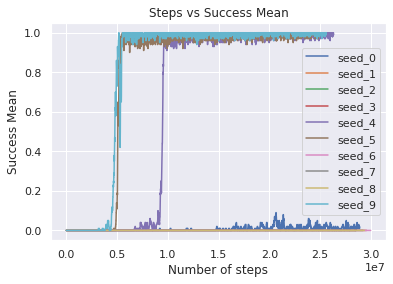

In [26]:
plt.figure()
plt.title('Steps vs Success Mean')
plt.ylabel('Success Mean')
plt.xlabel('Number of steps')

seed = 0
for d in all_subdirs: 
    if d == 'training_logs':
        continue
    else: 
        seed_name = 'seed_' + str(seed)
        csv_path = logdir + '/' + d + '/' + 'progress.csv'
        data = pd.read_csv(csv_path)
        steps = data['timesteps_total']
        success_mean= data['custom_metrics/outcome/success_mean']
        plt.plot(steps,success_mean,label=seed_name)
        seed = seed + 1
plt.legend()


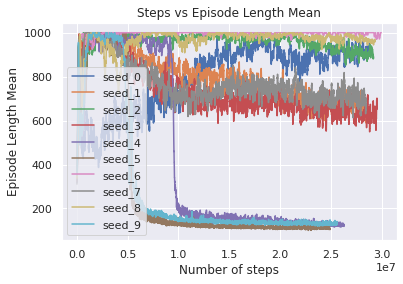

In [27]:
plt.figure()
plt.title('Steps vs Episode Length Mean')
plt.ylabel('Episode Length Mean')
plt.xlabel('Number of steps')

seed = 0
for d in all_subdirs: 
    if d == 'training_logs':
        continue
    else: 
        seed_name = 'seed_' + str(seed)
        csv_path = logdir + '/' + d + '/' + 'progress.csv'
        data = pd.read_csv(csv_path)
        steps = data['timesteps_total']
        success_mean= data['episode_len_mean']
        plt.plot(steps,success_mean,label=seed_name)
        seed = seed + 1

plt.legend()


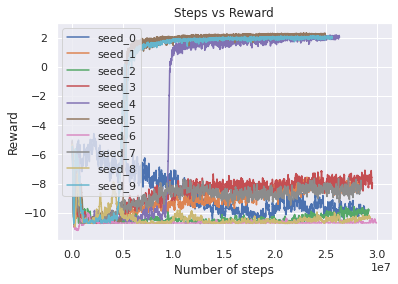

In [28]:
plt.figure()
plt.title('Steps vs Reward')
plt.ylabel('Reward')
plt.xlabel('Number of steps')

seed = 0
for d in all_subdirs: 
    if d == 'training_logs':
        continue
    else: 
        seed_name = 'seed_' + str(seed)
        csv_path = logdir + '/' + d + '/' + 'progress.csv'
        data = pd.read_csv(csv_path)
        steps = data['timesteps_total']
        success_mean= data['episode_reward_mean']
        plt.plot(steps,success_mean,label=seed_name)
        seed = seed + 1

plt.legend()


## Graphs for Paper 

In [29]:
# styling related 
sns.set_theme()

In [30]:
#clipping and interpolation follows
data_dfs = [pd.read_csv(csv_file_tracker[i]) for i in range(len(csv_file_tracker))]

In [31]:
from scipy import interpolate
sns.set_theme()

clipped_timesteps = data_dfs[5]['timesteps_total']

In [32]:
key_timesteps = 'timesteps_total'
key_eps_len_mean = 'episode_len_mean'
key_success_mean = 'custom_metrics/outcome/success_mean'
key_eps_reward_mean = 'episode_reward_mean'


In [33]:
timesteps_total_track = []
episode_len_mean_track = []
success_mean_track = []
eps_reward_mean_track = []

# dont need to walk through step by step , can just grab columns 
for ds in data_dfs:                
    timestep_total = ds[key_timesteps]
    episode_len_mean = ds[key_eps_len_mean]
    success_mean = ds[key_success_mean]
    reward_mean = ds[key_eps_reward_mean]
        
    # interpolation functions
    func_time_v_eps_len = interpolate.interp1d(timestep_total,episode_len_mean,fill_value='extrapolate')
    func_time_v_success = interpolate.interp1d(timestep_total,success_mean,fill_value='extrapolate')
    func_time_v_reward = interpolate.interp1d(timestep_total,reward_mean,fill_value='extrapolate')
    interp_eps_len = func_time_v_eps_len(clipped_timesteps)
    interp_success = func_time_v_success(clipped_timesteps)
    interp_reward = func_time_v_reward(clipped_timesteps)
        
    for i in clipped_timesteps:
        timesteps_total_track.append(i)
    for i in interp_eps_len: 
        episode_len_mean_track.append(i)
    for i in interp_success: 
        success_mean_track.append(i)
    for i in interp_reward: 
        eps_reward_mean_track.append(i)
        

In [34]:
timesteps_total_v_episode_len_mean = pd.DataFrame()
timesteps_total_v_episode_len_mean[key_timesteps] = timesteps_total_track
timesteps_total_v_episode_len_mean[key_eps_len_mean] = episode_len_mean_track

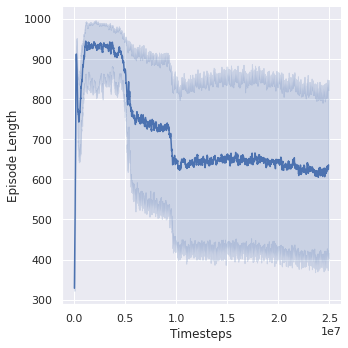

In [35]:
episode_mean_len_plot = sns.relplot(data=timesteps_total_v_episode_len_mean,x='timesteps_total',y='episode_len_mean',kind='line')
episode_mean_len_plot.set_axis_labels("Timesteps","Episode Length")


In [36]:
timesteps_total_v_success_mean = pd.DataFrame()
timesteps_total_v_success_mean[key_timesteps] = timesteps_total_track
timesteps_total_v_success_mean['success_mean'] = success_mean_track

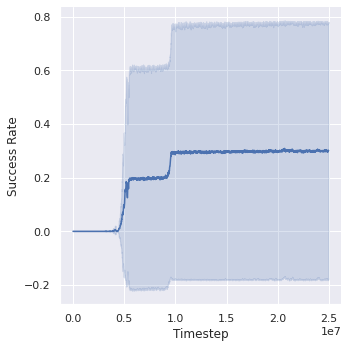

In [37]:
success_mean_plot = sns.relplot(data=timesteps_total_v_success_mean,x='timesteps_total',y='success_mean',ci='sd',kind='line')
success_mean_plot.set_axis_labels("Timestep","Success Rate") 

In [38]:
timesteps_total_v_episode_reward_mean = pd.DataFrame()
timesteps_total_v_episode_reward_mean[key_timesteps] = timesteps_total_track
timesteps_total_v_episode_reward_mean['episode_reward_mean'] = eps_reward_mean_track

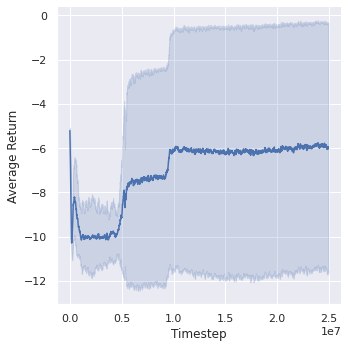

In [39]:
reward_plot = sns.relplot(data=timesteps_total_v_episode_reward_mean,x='timesteps_total',y='episode_reward_mean',ci='sd',kind='line')
reward_plot.set_axis_labels("Timestep","Average Return")

In [40]:
episode_mean_len_plot.savefig('rejoin3d_eps_len_plot.png',dpi=1200)
success_mean_plot.savefig('rejoin3d_success_mean.png',dpi=1200)
reward_plot.savefig('rejoin3d_reward_graph.png',dpi=1200)